# Table of contents

[Imports](#Imports)

[Feature preparation](#Feature-preparation)

[Checking correctness of recovery](#Checking-correctness-of-recovery)

[Missing features in test set](#Missing-features-in-test-set)

[Data preprocessing](#Data-preprocessing)

[Date conversion](#Date-conversion)

[Handling missing values](#Handling-missingvalues)

[Missing values due to zero input](#Missing-values-due-to-zero-input)

[Missing values in recovery that can be calculated](#Missing-values-in-recovery-that-can-be-calculated)

[Imputing randomly missing data with IterativeImputer](#Imputing-randomly-missing-data-with-IterativeImputer)

[Re-calculating train targets for remaining nulls](#Re-calculating-train-targets-for-remaining-nulls)

[Data analysis](#Data-analysis)

[Concentrations of metals distributions](#Concentrations-of-metals-distributions)

[feed particle size distributions](#feed-particle-size-distributions)

[Total concentrations of substances distributions](#Total-concentrations-of-substances-distributions)

[Building model](#Building-model)

[sMAPE](#sMAPE)

[Training models](#Training-models)

[Training model to predict final.output.recovery](#Training-model-to-predict-final.output.recovery)

[Decision Tree](#Decision-Tree)

[Random Forest](#Random-Forest)

[Linear Regression](#Linear-Regression)

[Training model to predict rougher.output.recovery](#Training-model-to-predict-rougher.output.recovery)

[Final evaluation](#Final-evaluation)

[Final evaluation of final.output.recovery](#Final-evaluation-of-final.output.recovery)

[Final evaluation of rougher.output.recovery](#Final-evaluation-of-rougher.output.recovery)

[Final sMAPE error](#Final-sMAPE-error)


# Imports

In [ ]:
#imports
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
import datetime as dt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score

# Feature preparation

In [3]:
#read files
data = {}
data['source'] = pd.read_csv('/datasets/gold_recovery_full.csv')
data['train'] = pd.read_csv('/datasets/gold_recovery_train.csv')
data['test'] = pd.read_csv('/datasets/gold_recovery_test.csv')

In [4]:
data['train'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [5]:
data['test'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

- All features have some missing data
- Target columns final.output.recovery , rougher.output.recovery are of different sizes and have missing entries
- Date feature needs to be transformed to numerical feature

## Checking correctness of recovery

Recovery = 100C(F-T)/F(C-T)

C = rougher.output.concentrate_au

F = rougher.input.feed_au

T = rougher.output.tail_au

In [6]:
def recovery_calc(C,F,T):
    return 100*C*(F-T)/((F*(C-T)).replace({ 0 : np.nan }))

In [7]:
c = 'rougher.output.concentrate_au'
f = 'rougher.input.feed_au'
t = 'rougher.output.tail_au'

final.output.recovery by formula:

Cfinal = final.output.concentrate_au

Ffinal = rougher.output.concentrate_au

Tfinal = secondary_cleaner.output.tail_au

In [8]:
c_f_1 = 'primary_cleaner.output.concentrate_au'
f_f_1 = 'rougher.output.concentrate_au'
t_f_1 = 'primary_cleaner.output.tail_au'

c_f_2 = 'final.output.concentrate_au'
f_f_2 = 'primary_cleaner.output.concentrate_au'
t_f_2 = 'secondary_cleaner.output.tail_au'

In [9]:
rougher_output_recovery_calculated = \
    recovery_calc(data['source'][c], \
                  data['source'][f], \
                  data['source'][t])

In [10]:
#checking there's no inf
rougher_output_recovery_calculated.max()

13802.071755686075

In [11]:
data['source']['rougher.output.recovery'].max()

100.0

Recovery has percentage units and should be max 100, results above this should be dropped because somwthing is probably wrong with one of C,F,T

Checking cases where denominator is zero:

In [12]:
data['source'].loc[data['source'][c]==data['source'][t],'rougher.output.recovery']

Series([], Name: rougher.output.recovery, dtype: float64)

In [13]:
data['source'].loc[data['source'][f]==0,[c,f,t,'rougher.output.recovery']]

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
99,0.0,0.0,NaN,NaN
100,0.0,0.0,NaN,NaN
101,0.0,0.0,NaN,NaN
102,0.0,0.0,NaN,NaN
103,0.0,0.0,NaN,NaN
...,...,...,...,...
17908,0.0,0.0,NaN,NaN
17909,0.0,0.0,NaN,NaN
17910,0.0,0.0,NaN,NaN
17911,0.0,0.0,NaN,NaN


In [14]:
data['source'].loc[90:140,['date', c,f,t,'rougher.output.recovery']]

,date,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
90,2016-01-18 18:00:00,18.935073,6.929477,1.769846,82.136396
91,2016-01-18 19:00:00,19.498176,7.338075,1.879700,82.320282
92,2016-01-18 20:00:00,19.380384,7.034778,1.949297,80.374740
93,2016-01-18 21:00:00,19.762929,7.174185,1.963684,80.641143
94,2016-01-18 22:00:00,19.796487,7.406371,2.070464,80.459926
95,2016-01-18 23:00:00,19.691709,7.105294,2.181507,77.930861
96,2016-01-19 00:00:00,19.399426,6.856598,2.040844,78.492873
97,2016-01-19 01:00:00,17.853024,7.421538,1.946899,82.795928
98,2016-01-19 02:00:00,7.624713,3.331100,2.774298,26.275908
99,2016-01-19 03:00:00,0.000000,0.000000,NaN,NaN


In [15]:
cols=data['source'].loc[99:128,:].notna().any()& (data['source'].loc[99:128,:]!=0).any()

In [16]:
data['source'].loc[99:128,data['source'].loc[99:128,:].notna().any()]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
99,2016-01-19 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.116168,...,13.985160,-799.601232,12.036072,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756
100,2016-01-19 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,14.034374,-799.600946,12.040491,-623.446329,9.898782,-499.623262,7.979302,-500.283366,11.959950,-600.998301
101,2016-01-19 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,13.943929,-799.600659,12.040238,-638.103348,9.956309,-499.791870,7.978806,-500.202026,11.987839,-600.302819
102,2016-01-19 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,14.040873,-799.600372,12.030771,-641.310327,9.966952,-499.842458,8.053455,-499.588522,11.987935,-600.523057
103,2016-01-19 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,13.972371,-799.600085,12.021058,-641.457227,10.033820,-501.291438,7.985956,-499.934267,12.027556,-600.108918
104,2016-01-19 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,13.932580,-799.599799,12.011345,-640.936879,10.004522,-500.021534,7.931758,-500.294773,12.026439,-600.301833
105,2016-01-19 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,13.989449,-799.599512,12.001631,-640.633205,9.932505,-499.399448,7.920371,-499.619457,11.997944,-600.538013
106,2016-01-19 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,13.990517,-799.598096,11.991918,-643.907378,9.956062,-499.882675,8.014221,-499.688721,11.998413,-600.345361
107,2016-01-19 11:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030815,...,13.904059,-799.591368,11.982703,-641.874749,10.016539,-498.372830,8.073042,-500.407344,11.981264,-599.271485
108,2016-01-19 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122067,...,13.944915,-799.583961,11.981382,-640.686792,9.943380,-500.557792,8.037255,-500.747732,12.008122,-600.379091


In [17]:
data['source'].loc[99:128,(data['source'].loc[99:128,:]==0).any()]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,...,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.tail_pb,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
data['source'].loc[((data['source'][f]!=0) &( data['source']['rougher.output.recovery'].isna())) \
                   ,[c,f,t,'rougher.output.recovery']]

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
53,3.507147,7.548341,2.187465,NaN
129,8.265500,2.436764,NaN,NaN
130,19.564930,3.818488,NaN,NaN
131,19.114878,3.331731,NaN,NaN
132,19.451740,6.203655,NaN,NaN
...,...,...,...,...
22553,6.038533,11.035269,1.343570,NaN
22554,10.712677,10.943209,1.858404,NaN
22555,0.010000,10.149224,1.729189,NaN
22556,0.010000,10.591710,1.481931,NaN


There are times with rougher.input.feed_au=0, meaning nothing enters the flotation process. These are MNAR for output columns and they should not be imputed in the same way like other missing at random values. Maybe it's possible to just drop them when training the model.

In [19]:
#number of missing values calculated
rougher_output_recovery_calculated.isna().sum()

2824

In [20]:
#number of missing values in the source data
data['source']['rougher.output.recovery'].isna().sum()

3119

In [21]:
rougher_output_recovery = pd.concat([rougher_output_recovery_calculated,data['source']['rougher.output.recovery']], axis=1)
rougher_output_recovery = rougher_output_recovery.dropna()

In [22]:
rougher_output_recovery.max()

0                          100.0
rougher.output.recovery    100.0
dtype: float64

In [23]:
mean_absolute_error(rougher_output_recovery.iloc[:,0],rougher_output_recovery.iloc[:,1])

1.1606241020277064e-14

MAE for recovery is extremely low, meaning this colums is correct and some of the random nulls can be filled with the calculation.

## Missing features in test set

In [24]:
#columns missing in test set
data['train'].columns.difference(data['test'].columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

The features that are missing in test set are the outcomes and residues of each stage of the process, and calculations of the rougher additions.

## Data preprocessing

### Date conversion

In [25]:
data['train']['date'].min()

'2016-01-15 00:00:00'

In [26]:
data['train']['date'].max()

'2018-08-18 10:59:59'

In [27]:
#converting to datetime format
data['train'].loc[:, 'date'] = pd.to_datetime(data['train'].loc[:, 'date'], format = '%Y-%m-%d %H:%M:%S')
data['train'].loc[:, 'date'].head()

0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
3   2016-01-15 03:00:00
4   2016-01-15 04:00:00
Name: date, dtype: datetime64[ns]

In [28]:
#converting to datetime format
data['test'].loc[:, 'date'] = pd.to_datetime(data['test'].loc[:, 'date'], format = '%Y-%m-%d %H:%M:%S')
data['test'].loc[:, 'date'].head()

0   2016-09-01 00:59:59
1   2016-09-01 01:59:59
2   2016-09-01 02:59:59
3   2016-09-01 03:59:59
4   2016-09-01 04:59:59
Name: date, dtype: datetime64[ns]

In [29]:
data['train'].loc[:, 'date'].dt.minute.unique()

array([ 0, 59])

In [30]:
data['source'].loc[:, 'date_old'] = data['source'].loc[:, 'date']
data['source'].loc[:, 'date'] = pd.to_datetime(data['test'].loc[:, 'date'], format = '%Y-%m-%d %H:%M:%S')

The minute and second are always the same, no need to extract both from daytime.

In [31]:
#adding date parts as features
data_prep = defaultdict(dict)
data_prep['train']['features'] =  data['train'].copy()
data_prep['train']['features'] = data_prep['train']['features'] \
                                .drop(['final.output.recovery','rougher.output.recovery'], axis=1)
data_prep['train']['targets'] = data['train'].loc[:, ['final.output.recovery','rougher.output.recovery']]
data_prep['test']['features'] = data['test'].copy()

for part in ['train', 'test']:
    for attr in ['year', 'month', 'day', 'hour', 'minute', 'dayofweek','dayofyear']:
        data_prep[part]['features'].loc[:,attr] = getattr(data_prep[part]['features'].loc[:,'date'].dt, attr)

In [32]:
for part in ['train', 'test']:
    data_prep[part]['features'].drop('date',axis=1, inplace=True)

In [33]:
#checking correlations between date parts
data_prep['train']['features'].corr().abs().loc \
[['year', 'month', 'day', 'hour', 'minute', 'dayofweek','dayofyear'], \
 ['year', 'month', 'day', 'hour', 'minute', 'dayofweek','dayofyear']]

,year,month,day,hour,minute,dayofweek,dayofyear
year,1.000000,0.073900,0.050280,0.000742,0.501726,0.003671,0.084959
month,0.073900,1.000000,0.042626,0.000949,0.351359,0.001161,0.991616
day,0.050280,0.042626,1.000000,0.000170,0.010605,0.001088,0.086395
hour,0.000742,0.000949,0.000170,1.000000,0.001503,0.000628,0.000971
minute,0.501726,0.351359,0.010605,0.001503,1.000000,0.005934,0.346926
dayofweek,0.003671,0.001161,0.001088,0.000628,0.005934,1.000000,0.001089
dayofyear,0.084959,0.991616,0.086395,0.000971,0.346926,0.001089,1.000000


dayofyear is highly correlated with month (0.99) therefore should be dropped

In [34]:
for part in ['train', 'test']:
    data_prep[part]['features'] = data_prep[part]['features'].drop('dayofyear',axis=1)

### Handling missing values

#### Missing values due to zero input

In [35]:
data_prep_backup = defaultdict(dict)
data_prep_backup['train']['features'] =  data_prep['train']['features'].copy()
data_prep_backup['train']['targets'] =  data_prep['train']['targets'].copy()
data_prep_backup['test']['features'] =  data_prep['test']['features'].copy()

Entries with zero inputs in test set:

In [36]:
inputs = ['rougher.input.feed_pb', 'rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_rate', \
         'rougher.input.feed_size', 'rougher.input.feed_sol']
data_prep['test']['features'].loc[data_prep['test']['features'][f]==0,inputs+[c,f,t]]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,rougher.input.feed_pb,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
31,0.0,0.0,0.0,0.211620,71.894046,0.0,NaN,0.0,NaN
32,0.0,0.0,0.0,65.388467,26.203151,0.0,NaN,0.0,NaN
169,0.0,0.0,0.0,402.748677,45.179769,0.0,NaN,0.0,NaN
170,0.0,0.0,0.0,403.464609,45.097351,0.0,NaN,0.0,NaN
171,0.0,0.0,0.0,403.688902,45.202892,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...
5489,0.0,0.0,0.0,NaN,25.362594,0.0,NaN,0.0,NaN
5490,0.0,0.0,0.0,NaN,25.365986,0.0,NaN,0.0,NaN
5491,0.0,0.0,0.0,NaN,25.369378,0.0,NaN,0.0,NaN
5492,0.0,0.0,0.0,139.602757,25.372771,0.0,NaN,0.0,NaN


In [37]:
#getting all dates where F=0 in test set
zero_input_dates_test =  data['test'].loc[((data['test'][f]==0)),'date']
#common_dates = pd.Index(zero_input_dates_test).intersection(pd.Index(zero_input_dates_source))

#searching for any rougher.output.recovery that is not null in above dates
data['source'].reindex(data['source']['date']) \
    .loc[pd.Index(zero_input_dates_test),'rougher.output.recovery'].notna().sum()

0

Since there are entries with zero input in test set and we are expected to predict their targets we can't drop them. A solution to this will be filling all missing inputs and outputs in the case of F=0 with zeros, including the targets in train set. In reality I would've ignored those measurments because they might lead to a wrong analysis of zero outputs.

In [38]:
data['source'].loc[data['source'][f]==0,data['source'].isna().any()]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
99,2016-09-05 03:59:59,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,13.985160,-799.601232,12.036072,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756
100,2016-09-05 04:59:59,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,14.034374,-799.600946,12.040491,-623.446329,9.898782,-499.623262,7.979302,-500.283366,11.959950,-600.998301
101,2016-09-05 05:59:59,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,13.943929,-799.600659,12.040238,-638.103348,9.956309,-499.791870,7.978806,-500.202026,11.987839,-600.302819
102,2016-09-05 06:59:59,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,14.040873,-799.600372,12.030771,-641.310327,9.966952,-499.842458,8.053455,-499.588522,11.987935,-600.523057
103,2016-09-05 07:59:59,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,13.972371,-799.600085,12.021058,-641.457227,10.033820,-501.291438,7.985956,-499.934267,12.027556,-600.108918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17908,NaT,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,20.005303,-500.893527,14.922286,-500.230461,10.909829,-500.314837,9.007956,-500.153163,10.988968,-500.387261
17909,NaT,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,19.962859,-655.489381,14.956567,-524.758657,10.961487,-500.066426,9.004925,-500.040902,10.961121,-500.023096
17910,NaT,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,20.017100,-523.801393,15.013965,-499.995375,10.991333,-499.941268,9.062215,-499.992738,10.996987,-499.871678
17911,NaT,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,19.947963,-521.792599,15.041185,-500.303435,10.980523,-500.095725,9.041985,-499.916563,11.010581,-500.083532


In [39]:
#countinh nulls in rougher.output.recovery in train set
data_prep['train']['targets']['rougher.output.recovery'].isna().sum()

2573

In [40]:
#viewing some output columns where F=0
data['source'].loc[data['source'][f]==0,:].filter(regex=(".*output.*"))

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
99,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17908,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
17909,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
17910,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
17911,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0


In [41]:
data['source'].loc[data['source'][f]==0,:].filter(regex=(".*output.*")).notna().any()

final.output.concentrate_ag                True
final.output.concentrate_pb                True
final.output.concentrate_sol               True
final.output.concentrate_au                True
final.output.recovery                     False
final.output.tail_ag                       True
final.output.tail_pb                       True
final.output.tail_sol                      True
final.output.tail_au                       True
primary_cleaner.output.concentrate_ag      True
primary_cleaner.output.concentrate_pb      True
primary_cleaner.output.concentrate_sol     True
primary_cleaner.output.concentrate_au      True
primary_cleaner.output.tail_ag             True
primary_cleaner.output.tail_pb             True
primary_cleaner.output.tail_sol            True
primary_cleaner.output.tail_au             True
rougher.output.concentrate_ag              True
rougher.output.concentrate_pb              True
rougher.output.concentrate_sol             True
rougher.output.concentrate_au           

In [42]:
#viewing some input columns where F=0
data['source'].loc[data['source'][f]==0,:].filter(regex=(".*input.*"))

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate
99,2.116168,NaN,7.25,NaN,0.0,0.0,0.342757,30.525966,0.0,0.0,NaN,0.005591,NaN,NaN
100,NaN,NaN,7.25,0.003844,0.0,0.0,0.334574,30.522523,0.0,0.0,NaN,0.001380,0.000254,NaN
101,NaN,NaN,7.25,NaN,0.0,0.0,0.327750,30.519080,0.0,0.0,NaN,0.000214,NaN,NaN
102,NaN,NaN,7.25,NaN,0.0,0.0,0.325795,30.515637,0.0,0.0,NaN,0.001809,0.012934,NaN
103,NaN,NaN,7.25,NaN,0.0,0.0,0.320781,30.512194,0.0,0.0,NaN,0.003620,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17908,NaN,NaN,6.94,0.005618,0.0,0.0,0.036174,30.481149,0.0,0.0,NaN,0.003049,NaN,NaN
17909,NaN,NaN,6.94,NaN,0.0,0.0,0.054788,30.480077,0.0,0.0,NaN,NaN,NaN,NaN
17910,NaN,NaN,6.94,NaN,0.0,0.0,0.055057,30.479834,0.0,0.0,NaN,0.003140,NaN,NaN
17911,NaN,NaN,6.94,NaN,0.0,0.0,0.043394,30.481489,0.0,0.0,NaN,NaN,NaN,NaN


In [43]:
#share of nulls in output columns where F=0
data['source'].filter(regex=(".*output.*")).loc[data['source'][f]==0,:].isna().sum()/ \
    data['source'].loc[data['source'][f]==0,:].shape[0]

final.output.concentrate_ag               0.004581
final.output.concentrate_pb               0.004581
final.output.concentrate_sol              0.004581
final.output.concentrate_au               0.004581
final.output.recovery                     1.000000
final.output.tail_ag                      0.004581
final.output.tail_pb                      0.004581
final.output.tail_sol                     0.075262
final.output.tail_au                      0.004581
primary_cleaner.output.concentrate_ag     0.000000
primary_cleaner.output.concentrate_pb     0.030759
primary_cleaner.output.concentrate_sol    0.038613
primary_cleaner.output.concentrate_au     0.000000
primary_cleaner.output.tail_ag            0.000000
primary_cleaner.output.tail_pb            0.000000
primary_cleaner.output.tail_sol           0.020942
primary_cleaner.output.tail_au            0.000000
rougher.output.concentrate_ag             0.000000
rougher.output.concentrate_pb             0.000000
rougher.output.concentrate_sol 

In [44]:
#share of nulls in input columns where F=0
data['source'].filter(regex=(".*input.*")).loc[data['source'][f]==0,:].isna().sum()/ \
    data['source'].loc[data['source'][f]==0,:].shape[0]

primary_cleaner.input.sulfate         0.711387
primary_cleaner.input.depressant      0.742801
primary_cleaner.input.feed_size       0.000000
primary_cleaner.input.xanthate        0.495419
rougher.input.feed_ag                 0.000000
rougher.input.feed_pb                 0.000000
rougher.input.feed_rate               0.143979
rougher.input.feed_size               0.125654
rougher.input.feed_sol                0.000000
rougher.input.feed_au                 0.000000
rougher.input.floatbank10_sulfate     0.536649
rougher.input.floatbank10_xanthate    0.198953
rougher.input.floatbank11_sulfate     0.159031
rougher.input.floatbank11_xanthate    0.852094
dtype: float64

Examining some columns with share of nulls < 0.5. It's seen that in the case of:

primary_cleaner.input.xanthate

rougher.input.floatbank10_xanthate

rougher.input.floatbank11_sulfate

their non null values are close to zero or rare outliers. Thus I chose to impute them with 0.

In [45]:
data['source']['primary_cleaner.input.xanthate'].describe()

count    21565.000000
mean         0.969830
std          0.548083
min          0.000003
25%          0.626346
50%          0.905286
75%          1.200734
max          6.027907
Name: primary_cleaner.input.xanthate, dtype: float64

In [46]:
data['source'].loc[data['source'][f]==0,'primary_cleaner.input.xanthate'].describe()

count    771.000000
mean       0.180419
std        0.584374
min        0.000003
25%        0.003009
50%        0.006619
75%        0.013548
max        6.027907
Name: primary_cleaner.input.xanthate, dtype: float64

In [47]:
data['source']['rougher.input.floatbank10_xanthate'].describe()

count    22247.000000
mean         5.573526
std          1.908123
min          0.000003
25%          5.046782
50%          5.999078
75%          6.700493
max         31.493331
Name: rougher.input.floatbank10_xanthate, dtype: float64

In [48]:
data['source'].loc[data['source'][f]==0,'rougher.input.floatbank10_xanthate'].describe()

count    1224.000000
mean        0.650619
std         1.792380
min         0.000003
25%         0.003270
50%         0.006322
75%         0.012785
max        13.037750
Name: rougher.input.floatbank10_xanthate, dtype: float64

In [49]:
data['source']['rougher.input.floatbank11_sulfate'].describe()

count    22038.000000
mean        11.209718
std          4.685205
min          0.000014
25%          9.281388
50%         11.946466
75%         14.015696
max         37.980648
Name: rougher.input.floatbank11_sulfate, dtype: float64

In [50]:
data['source'].loc[data['source'][f]==0,'rougher.input.floatbank11_sulfate'].describe()

count    1285.000000
mean        0.861152
std         3.019699
min         0.000014
25%         0.011652
50%         0.025104
75%         0.042677
max        28.949609
Name: rougher.input.floatbank11_sulfate, dtype: float64

In [51]:
data['source']['rougher.input.feed_size'].describe()

count    22277.000000
mean        57.959166
std         23.644823
min          0.046369
25%         46.687088
50%         53.405122
75%         64.096151
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [52]:
data['source'].loc[data['source'][f]==0,'rougher.input.feed_size'].describe()

count    1336.000000
mean       46.507934
std        32.270798
min         5.741424
25%        30.527560
50%        45.205125
75%        48.026945
max       339.965304
Name: rougher.input.feed_size, dtype: float64

In [53]:
data['source']['rougher.input.feed_rate'].describe()

count    22163.000000
mean       441.873650
std        156.736078
min          0.000044
25%        398.222097
50%        488.968597
75%        546.587401
max        717.508837
Name: rougher.input.feed_rate, dtype: float64

In [54]:
data['source'].loc[data['source'][f]==0,'rougher.input.feed_rate'].describe()

count    1308.000000
mean       29.598469
std        99.221842
min         0.000044
25%         0.154231
50%         0.204301
75%         1.500220
max       598.762701
Name: rougher.input.feed_rate, dtype: float64

In [55]:
#columns with MNAR to fill with zeroes in case F=0 
cols_to_zero_output = ['rougher.output.tail_ag', 'rougher.output.tail_sol','rougher.output.tail_au']
cols_to_zero_input = ['primary_cleaner.input.sulfate','primary_cleaner.input.depressant', \
                      'primary_cleaner.input.xanthate','rougher.input.floatbank10_sulfate', \
                      'rougher.input.floatbank10_xanthate','rougher.input.floatbank11_sulfate', \
                     'rougher.input.floatbank11_xanthate']
cols_to_zero_target = ['rougher.output.recovery','final.output.recovery']

In [56]:
#filling MNAR null columns in case F=0 with zeros
data_prep['train']['targets'].loc[data_prep['train']['features'][f]==0,cols_to_zero_target] = \
data_prep['train']['targets'].loc[data_prep['train']['features'][f]==0,cols_to_zero_target].fillna(0) 

data_prep['train']['features'].loc[data_prep['train']['features'][f]==0,cols_to_zero_output+cols_to_zero_input] = \
data_prep['train']['features'].loc[data_prep['train']['features'][f]==0,cols_to_zero_output+cols_to_zero_input] \
    .fillna(0)

data_prep['test']['features'].loc[data_prep['test']['features'][f]==0,cols_to_zero_input] = \
data_prep['test']['features'].loc[data_prep['test']['features'][f]==0,cols_to_zero_input].fillna(0)

In [57]:
data_prep['train']['targets'].loc[data_prep['train']['features'][f]==0,cols_to_zero_target].isna().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

#### Missing values in recovery that can be calculated

In [58]:
rougher_output_recovery_calculated = \
    recovery_calc(data_prep['train']['features'][c], \
                  data_prep['train']['features'][f], \
                  data_prep['train']['features'][t])

In [59]:
rougher_output_recovery_calculated.describe()

count     14547.000000
mean         31.414147
std        3302.773106
min     -366924.161290
25%          79.704808
50%          85.229912
75%          90.203432
max       13802.071756
dtype: float64

In [60]:
data_prep['train']['targets']['rougher.output.recovery'].describe()

count    15446.000000
mean        76.211702
std         26.115516
min          0.000000
25%         77.946158
50%         84.401756
75%         89.762581
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [61]:
sum(rougher_output_recovery_calculated>100)

124

In [62]:
ind_above_100 = rougher_output_recovery_calculated[(rougher_output_recovery_calculated>100)].index
ind_less_0 = rougher_output_recovery_calculated[(rougher_output_recovery_calculated<0)].index

In [63]:
data_prep['train']['targets'].loc[ind_above_100,:]

,final.output.recovery,rougher.output.recovery
53,71.308281,NaN
835,78.126966,NaN
837,79.990029,NaN
2058,0.000000,NaN
2072,52.989622,NaN
...,...,...
16525,62.269862,NaN
16647,77.295186,NaN
16653,73.685150,NaN
16697,70.871419,NaN


In [64]:
data_prep['train']['targets'].loc[ind_above_100,:] \
    .loc[(data_prep['train']['targets']['final.output.recovery'].isna())& \
         (data_prep['train']['targets']['rougher.output.recovery'].isna())]

,final.output.recovery,rougher.output.recovery
13189,NaN,NaN
15606,NaN,NaN


Recovery values must be lower than 100%, values above this might indicate a problem with measurments of share of gold so I chose to drop these entries.

In [65]:
#viewing entries with recovery=100
data_prep['train']['features'].loc[data_prep['train']['targets']['rougher.output.recovery']==100,[c,f,t,c_f_2]]

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,final.output.concentrate_au
12567,0.01,0.01,1.055084,19.959119
13035,0.01,0.01,1.352458,45.270618
13036,0.01,0.01,1.352458,45.270618
13037,0.01,0.01,1.352458,45.270618
13038,0.01,0.01,1.352458,45.270618
13039,0.01,0.01,1.352458,35.424183


In [66]:
#viewing entries with recovery=100 in calculated series
data_prep['train']['features'].loc[rougher_output_recovery_calculated==100,[c,f,t,c_f_2]]

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,final.output.concentrate_au
12567,0.01,0.01,1.055084,19.959119
13035,0.01,0.01,1.352458,45.270618
13036,0.01,0.01,1.352458,45.270618
13037,0.01,0.01,1.352458,45.270618
13038,0.01,0.01,1.352458,45.270618
13039,0.01,0.01,1.352458,35.424183


In [67]:
data_prep['train']['targets']. \
    loc[data_prep['train']['targets']['rougher.output.recovery']==100,'final.output.recovery']

12567      NaN
13035    100.0
13036    100.0
13037    100.0
13038    100.0
13039    100.0
Name: final.output.recovery, dtype: float64

It's clear that rougher recovery=100 is due to C=F~0 and not because T=0 as it should have been. But secondary tails ended up to be 0 with significant values of final.output.concentrate_au so final recoverys are also 100%. I chose to keep those entries as they are because we might have similar states in test set with a problem of measuring the shares of gold incorrectly and with the information I have I can't take a decision to replace 0.01 with nulls and impute them.

In [68]:
#viewing entries with C=F
data_prep['train']['features'] \
    .loc[(data_prep['train']['features'][c]==data_prep['train']['features'][f]) & \
         (data_prep['train']['features'][f]!=0),[c,f,t,c_f_2]]

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,final.output.concentrate_au
12567,0.01,0.01,1.055084,19.959119
12568,0.01,0.01,NaN,0.010000
12569,0.01,0.01,NaN,0.010000
12579,0.01,0.01,NaN,0.010000
12580,0.01,0.01,NaN,0.010000
...,...,...,...,...
16600,0.01,0.01,NaN,0.010000
16608,0.01,0.01,NaN,0.010000
16609,0.01,0.01,NaN,0.010000
16610,0.01,0.01,NaN,0.010000


In [69]:
#viewing entries with C=F
data_prep['train']['targets'] \
    .loc[(data_prep['train']['features'][c]==data_prep['train']['features'][f]) & \
         (data_prep['train']['features'][f]!=0),:]

,final.output.recovery,rougher.output.recovery
12567,NaN,100.0
12568,100.0,NaN
12569,100.0,NaN
12579,100.0,NaN
12580,100.0,NaN
...,...,...
16600,100.0,NaN
16608,100.0,NaN
16609,100.0,NaN
16610,100.0,NaN


In [70]:
data_prep['train']['features'].loc[16590:16620,[c,f,t,c_f_2]]

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,final.output.concentrate_au
16590,20.521130,11.863354,1.903286,42.945831
16591,20.562069,12.005990,1.820987,42.761676
16592,20.708193,11.807350,1.930852,42.662460
16593,20.923045,11.522702,1.930867,42.560362
16594,21.094010,11.371030,1.822246,43.381992
16595,21.275088,11.316472,1.799993,43.483623
16596,20.738328,11.505700,1.822655,43.821659
16597,18.640711,10.536458,1.862140,41.797163
16598,0.010000,0.010000,NaN,0.010000
16599,0.010000,0.010000,NaN,0.010000


In [71]:
data_prep['train']['features'].loc[12565:12582,[c,f,t,c_f_2]]

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,final.output.concentrate_au
12565,20.897041,9.576846,1.382316,42.664982
12566,16.950554,5.076892,1.253020,41.084515
12567,0.010000,0.010000,1.055084,19.959119
12568,0.010000,0.010000,NaN,0.010000
12569,0.010000,0.010000,NaN,0.010000
12570,6.019845,2.554853,NaN,0.010000
12571,4.895342,8.406709,NaN,0.010000
12572,0.010000,9.019502,1.627054,25.122485
12573,6.522357,9.024151,1.369989,44.530603
12574,20.183013,8.526371,1.163734,44.213838


In [72]:
#viewing entries with C=F=C_f~0.01
data_prep['train']['features'] \
    .loc[(data_prep['train']['features'][c]==data_prep['train']['features'][f]) & \
         (data_prep['train']['features'][c]==data_prep['train']['features'][c_f_2]) & \
         (data_prep['train']['features'][f]<=0.01) & \
         (data_prep['train']['features'][f]!=0),[c,f,t,c_f_2]]

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,final.output.concentrate_au
12568,0.01,0.01,NaN,0.01
12569,0.01,0.01,NaN,0.01
12579,0.01,0.01,NaN,0.01
12580,0.01,0.01,NaN,0.01
12581,0.01,0.01,NaN,0.01
...,...,...,...,...
16600,0.01,0.01,NaN,0.01
16608,0.01,0.01,NaN,0.01
16609,0.01,0.01,NaN,0.01
16610,0.01,0.01,NaN,0.01


I chose to drop 335 entries with C=F=C_f=0.01 which result in targets = 100% or null

In [73]:
mask_001 = (data_prep['train']['features'][c]==data_prep['train']['features'][f]) & \
         (data_prep['train']['features'][c]==data_prep['train']['features'][c_f_2]) & \
         (data_prep['train']['features'][f]<=0.01) & \
         (data_prep['train']['features'][f]!=0)
ind_001 = data_prep['train']['features'][mask_001].index

In [74]:
#counting nulls before filling with calculated values or dropping data
data_prep['train']['targets']['rougher.output.recovery'].isna().sum()

1414

In [75]:
#dropping recovery above 100%
data_prep['train']['features'] = data_prep['train']['features'].drop(ind_above_100)
data_prep['train']['targets'] = data_prep['train']['targets'].drop(ind_above_100)
rougher_output_recovery_calculated = rougher_output_recovery_calculated.drop(ind_above_100)

In [76]:
#dropping recovery less than 0
data_prep['train']['features'] = data_prep['train']['features'].drop(ind_less_0)
data_prep['train']['targets'] = data_prep['train']['targets'].drop(ind_less_0)
rougher_output_recovery_calculated = rougher_output_recovery_calculated.drop(ind_less_0)

In [77]:
#dropping C=F=C_f~0.01
data_prep['train']['features'] = data_prep['train']['features'].drop(ind_001)
data_prep['train']['targets'] = data_prep['train']['targets'].drop(ind_001)
rougher_output_recovery_calculated = rougher_output_recovery_calculated.drop(ind_001)

In [78]:
data_prep['train']['targets']['rougher.output.recovery'].isna().sum()

819

In [79]:
#filling part of rougher.output.recovery with calculated values
data_prep['train']['targets'].loc[:,'rougher.output.recovery'] = \
data_prep['train']['targets'].loc[:,'rougher.output.recovery'].fillna(rougher_output_recovery_calculated)

data_prep['train']['targets']['rougher.output.recovery'].isna().sum()

819

No extra information added from calculations.

In [80]:
#share of nulls in rougher.output.recovery
data_prep['train']['targets']['rougher.output.recovery'].isna().sum()/ \
    data_prep['train']['targets']['rougher.output.recovery'].shape[0]

0.05035351982785122

In [81]:
#share of nulls in final.output.recovery
data_prep['train']['targets']['final.output.recovery'].isna().sum()/ \
    data_prep['train']['targets']['final.output.recovery'].shape[0]

0.02004303719643406

Now about 2% of final.output.recovery targets are missing, and should be re calculated after features imputation or be dropped since they are not usefull for predicting test targets.

In [82]:
#getting indices where rougher.output.recovery is null but final.output.recovery isn't
ind = (data_prep['train']['targets']['final.output.recovery'].notna()) & \
                              (data_prep['train']['targets']['rougher.output.recovery']).isna()

In [83]:
#viewing C,F,T in the above cases
data_prep['train']['features'].loc[ind,[c,f,t]]

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
130,19.564930,3.818488,NaN
131,19.114878,3.331731,NaN
132,19.451740,6.203655,NaN
133,19.763979,7.372952,NaN
134,19.440842,8.032530,NaN
...,...,...,...
16602,26.592025,9.809395,NaN
16603,25.492435,9.844695,NaN
16604,23.247977,11.057542,NaN
16612,1.325702,4.988064,NaN


The extra 3% missing values in rougher.output.recovery is due to missing rougher.output.tail_au, and can be re calculated after imputation of features. It's important to see that missing values occur in continuous chunks, so it's not necessarily possible to fill them with a simple 1-nearest neighbor.

In [84]:
data_prep['train']['features'].loc[120:150,[c,f,t]]

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
120,0.000000,0.000000,0.000000
121,0.000000,0.000000,0.000000
122,0.000000,0.000000,0.000000
123,0.000000,0.000000,0.000000
124,0.000000,0.000000,0.000000
125,0.000000,0.000000,0.000000
126,0.000000,0.000000,0.000000
127,0.000000,0.000000,0.000000
128,0.000000,0.000000,0.000000
129,8.265500,2.436764,NaN


In [85]:
na_final_output_recovery =  \
    data_prep['train']['targets']['final.output.recovery'] \
        [data_prep['train']['targets']['final.output.recovery'].isna()].index

In [86]:
data_prep['train']['features'].loc[na_final_output_recovery,[c_f_2,f_f_1,t_f_1, t_f_2]]

,final.output.concentrate_au,rougher.output.concentrate_au,primary_cleaner.output.tail_au,secondary_cleaner.output.tail_au
49,43.389252,0.000000,4.638089,5.401810
129,0.000000,8.265500,0.341507,0.473344
375,23.704807,7.789100,2.639823,6.307049
379,0.000000,0.000000,0.000000,0.000000
380,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
16800,40.001769,20.249787,5.928391,5.980612
16801,38.769032,20.736825,7.466132,7.652057
16802,32.852508,20.644033,10.553873,10.625071
16803,37.019149,20.316798,8.576451,11.391350


In [87]:
data_prep['train']['targets'].iloc[47:52,:]

,final.output.recovery,rougher.output.recovery
47,55.088448,0.0
48,41.962008,0.0
49,NaN,0.0
50,49.884856,0.0
51,68.638723,0.0


In [88]:
#dropping final.output.recovery nulls
data_prep['train']['features'] = data_prep['train']['features'].drop(na_final_output_recovery)
data_prep['train']['targets'] = data_prep['train']['targets'].drop(na_final_output_recovery)
rougher_output_recovery_calculated = rougher_output_recovery_calculated.drop(na_final_output_recovery)

In [89]:
#share of rougher.output.recovery nulls
data_prep['train']['targets']['rougher.output.recovery'].isna().sum()/ \
    data_prep['train']['targets']['rougher.output.recovery'].shape[0]

0.03958843089277872

In [90]:
na_cols = data_prep['train']['features'].columns[data_prep['train']['features'].isna().any()]

In [91]:
na_rows = data_prep['train']['features'][data_prep['train']['features'].isna().any(axis=1)].index

#### Imputing randomly missing data with IterativeImputer

In [92]:
#columns in train features missing in test features
col_diff = data_prep['train']['features'].columns.difference(data_prep['test']['features'].columns)

In [93]:
def impute_data(train_data, valid_data=None, random_state=12345):
    imp = IterativeImputer(max_iter=5, random_state=random_state)
    imp.fit(train_data)
    train_imputed = train_data.copy()
    train_imputed.loc[:,:] = imp.transform(train_data)
    if valid_data is not None:
        valid_imputed = valid_data.copy()
        valid_imputed.loc[:,:] = imp.transform(valid_data)
    else:
        valid_imputed = None
    return train_imputed,valid_imputed

In [94]:
#imputing missing data in train, test features using iterative imputer
imputed_data = defaultdict(dict)
imputed_data['train']['targets'] = data_prep['train']['targets'].copy()
imputed_data['train']['features'] = data_prep['train']['features'].drop(col_diff, axis=1)
imputed_data['test']['features'] = data_prep['test']['features'].copy()

imputed_data['train']['features'], imputed_data['test']['features'] = \
    impute_data(imputed_data['train']['features'], imputed_data['test']['features'], random_state=12345)

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


This training set is for use in final fitting. When tuning model's parameters the imputation will be done inside cross validation stage.

#### Re-calculating train targets for remaining nulls 

In order to calculate missing rougher.output.recovery, I'll impute all features of train set:

In [95]:
#imputing missing data in train, test features using iterative imputer

imputed =  impute_data(data_prep['train']['features'])[0]

In [96]:
rougher_output_recovery_re_calculated =  \
        recovery_calc(
        imputed[c], \
        imputed[f], \
        imputed[t])

In [97]:
ind_above_100 = rougher_output_recovery_re_calculated[(rougher_output_recovery_re_calculated>100)].index
ind_less_0 = rougher_output_recovery_re_calculated[(rougher_output_recovery_re_calculated<0)].index

In [98]:
ind_above_100

Int64Index([ 2212,  2400,  5488,  7214,  7329,  9075,  9076, 11628, 11630,
            11638, 13555, 16155, 16478, 16494, 16612],
           dtype='int64')

In [99]:
rougher_output_recovery_re_calculated = rougher_output_recovery_re_calculated.drop(ind_above_100)
rougher_output_recovery_re_calculated = rougher_output_recovery_re_calculated.drop(ind_less_0)

In [100]:
rougher_output_recovery_re_calculated.describe()

count    14753.000000
mean        82.719526
std         14.780735
min         -0.000000
25%         80.105721
50%         85.493085
75%         90.328183
max        100.000000
dtype: float64

In [101]:
rougher_output_recovery_re_calculated.isna().sum()

1159

In [102]:
imputed_data['train']['targets'].loc[:,'rougher.output.recovery'] = \
    imputed_data['train']['targets'].loc[:,'rougher.output.recovery'].fillna(rougher_output_recovery_re_calculated)
imputed_data['train']['targets']['rougher.output.recovery'].isna().sum()

27

In [103]:
imputed_data['train']['targets'].describe()

,final.output.recovery,rougher.output.recovery
count,15939.000000,15912.000000
mean,61.600570,76.694392
std,20.229674,25.781373
min,0.000000,0.000000
25%,60.752891,78.206708
50%,66.686352,84.676074
75%,71.927140,89.967162
max,100.000000,100.000000


In [104]:
imputed_data['train']['targets']['final.output.recovery'].isna().sum()

0

Removing remaining nulls in rougher output:

In [105]:
na_ind = imputed_data['train']['targets'][imputed_data['train']['targets']['rougher.output.recovery'].isna()].index
imputed_data['train']['features'] = imputed_data['train']['features'].drop(na_ind)
imputed_data['train']['targets'] = imputed_data['train']['targets'].dropna()
imputed_data['train']['targets']['final.output.recovery'].isna().sum()

0

In [106]:
imputed_data['train']['targets'].shape

(15912, 2)

In [107]:
imputed_data['train']['features'].shape

(15912, 58)

In [108]:
imputed = imputed.drop(na_ind)
imputed.shape

(15912, 90)

In [109]:
data_prep['train']['features'] = data_prep['train']['features'].drop(na_ind)
data_prep['train']['targets'] = data_prep['train']['targets'].drop(na_ind)
data_prep['train']['features'].shape

(15912, 90)

In [110]:
data_prep['train']['targets'].shape

(15912, 2)

# Data analysis

## Concentrations of metals distributions

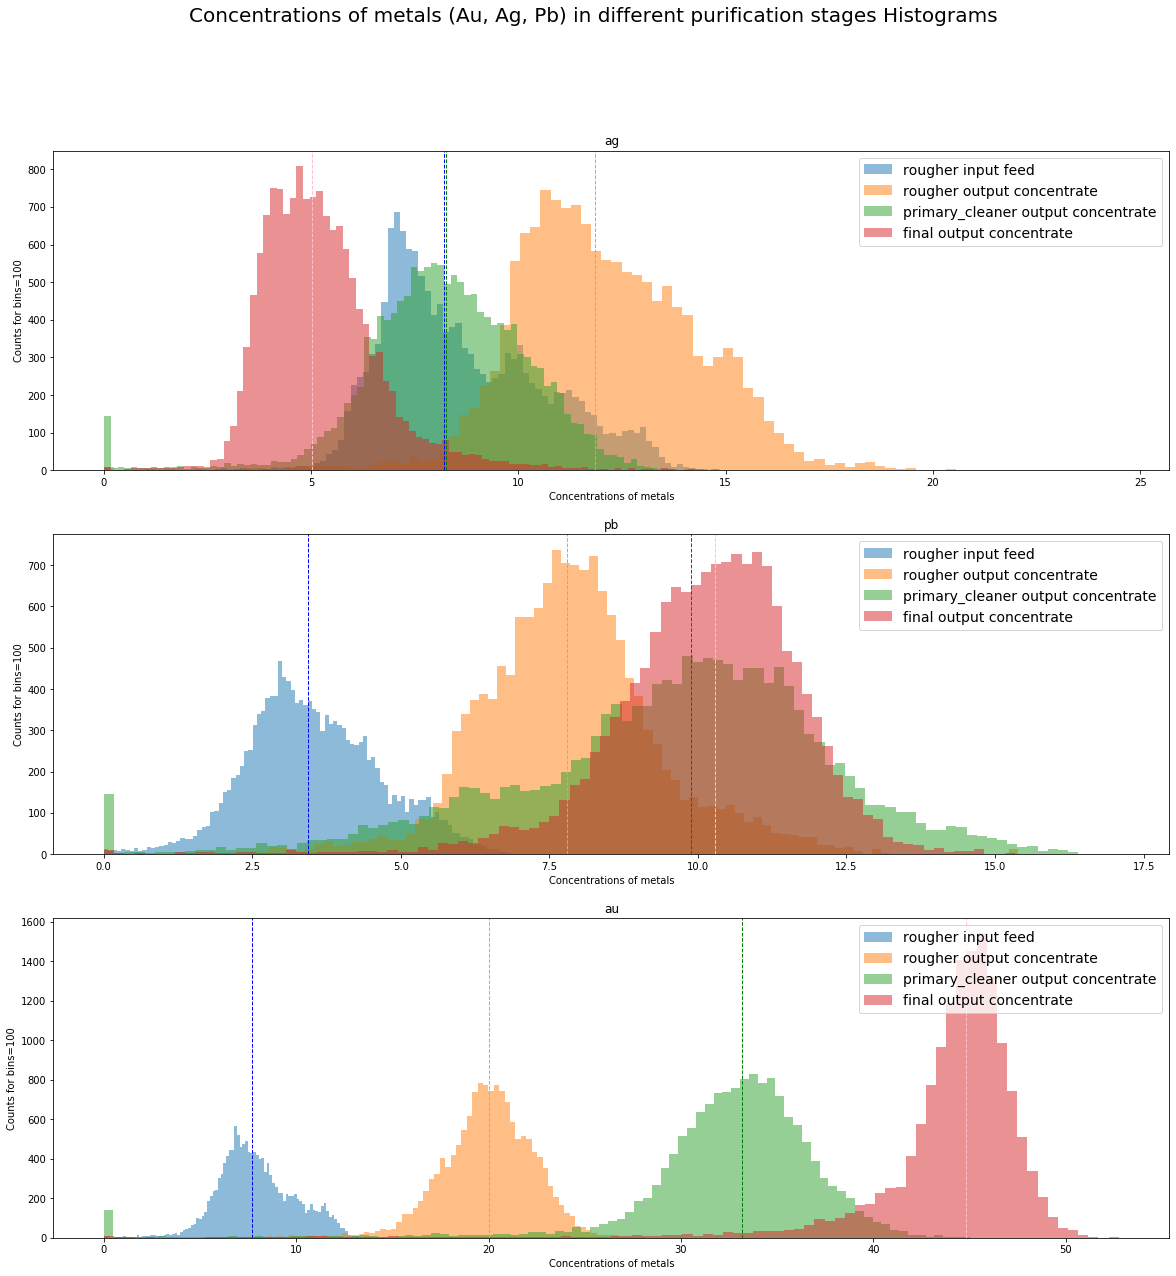

In [111]:
colors = ['orange','g','pink']
plt.figure(figsize=(20,20))
plt.suptitle('Concentrations of metals (Au, Ag, Pb) in different purification stages Histograms', fontsize=20)
i=0
for m in ['ag','pb','au']:
    plt.subplot(3,1,i+1)
    plt.hist(imputed.loc[imputed['rougher.input.feed_'+m]>0,'rougher.input.feed_'+m], \
             bins=100,alpha=0.5, label='rougher input feed')
    plt.axvline(imputed.loc[imputed['rougher.input.feed_'+m]>0, 'rougher.input.feed_'+m].median(), \
                color='b', linestyle='dashed', linewidth=1)
    j=0
    for stage in ['rougher', 'primary_cleaner','final']:
        plt.hist(imputed.loc[imputed[stage+'.output.concentrate_'+m]>0, stage+'.output.concentrate_'+m], \
                 bins=100,alpha=0.5, label=stage+' output concentrate')
        plt.axvline(imputed.loc[imputed[stage+'.output.concentrate_'+m]>0, stage+'.output.concentrate_'+m].median(), \
                    color=colors[j], linestyle='dashed', linewidth=1)
        j+=1
    plt.xlabel('Concentrations of metals')
    plt.ylabel('Counts for bins=100')
    plt.legend(loc='upper right', fontsize=14)
    plt.title(m)
    i+=1

- Gold concentration is gradually increased with purification stages, with medians changing from <10% to 45%
- Ag concentration is increased in flotation but then decreased in purification as wanted, with medians changing from ~7% to ~5%
- Pb concentration is increased but much less significanly than gold's, with medians changing from ~3% to ~10%

## feed particle size distributions

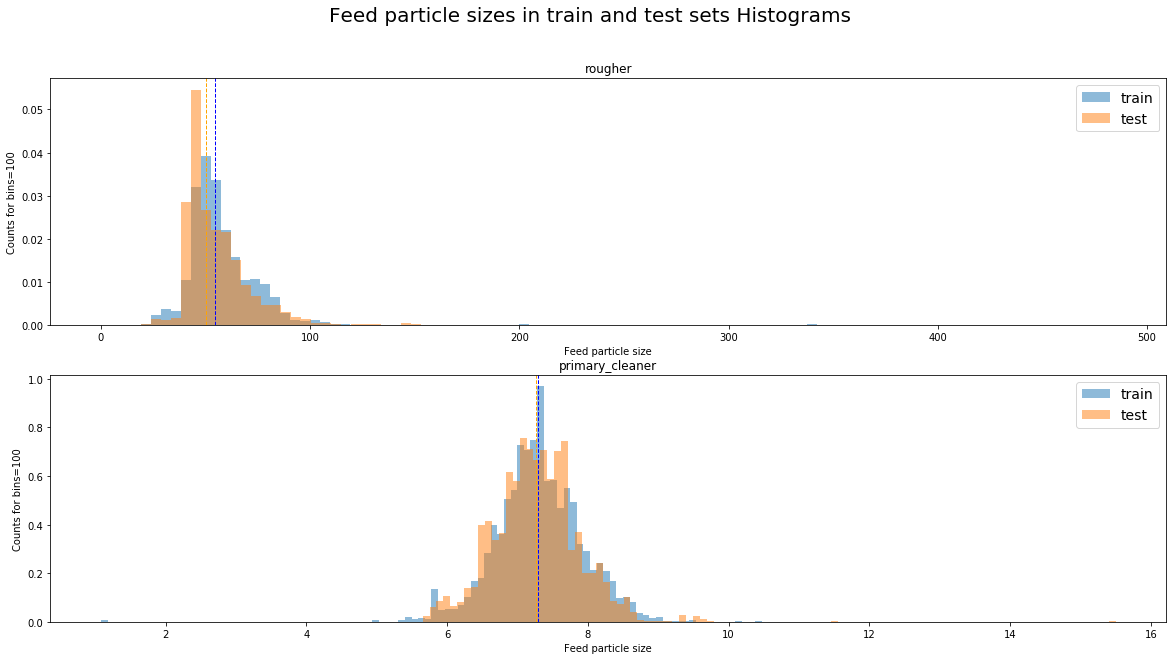

In [117]:
#plotting normalized histograms of particle sizes
colors = ['b','orange']
plt.figure(figsize=(20,10))
plt.suptitle('Feed particle sizes in train and test sets Histograms', fontsize=20)
i=0
for stage in ['rougher', 'primary_cleaner']:
    plt.subplot(2,1,i+1)
    j=0
    for s in ['train','test']:
        plt.hist(imputed_data[s]['features'][stage+'.input.feed_size'], \
                 bins=100,alpha=0.5,density=True, label=s)
        med = imputed_data[s]['features'][stage+'.input.feed_size'].median()
        plt.axvline(med, \
                    color=colors[j], linestyle='dashed', linewidth=1)
        #plt.text(med+j-0.5,700+100*j, str(round(med,2)),rotation=0)
        j+=1
    plt.xlabel('Feed particle size')
    plt.ylabel('Counts for bins=100')
    plt.legend(loc='upper right', fontsize=14)
    plt.title(stage)
    i+=1

In [131]:
imputed_data['test']['features'].loc[:, 'rougher'+'.input.feed_size'].max()

477.44547252313856

In [132]:
imputed_data['train']['features'].loc[:, 'rougher'+'.input.feed_size'].max()

484.96746649397346

The normalized distributions in train and test sets look similar, but the median in rougher stage is a little higher in train set. It is not possible to remove outliers in train set since test set has outliers as well and we are expected to predict for those entries.

## Total concentrations of substances distributions

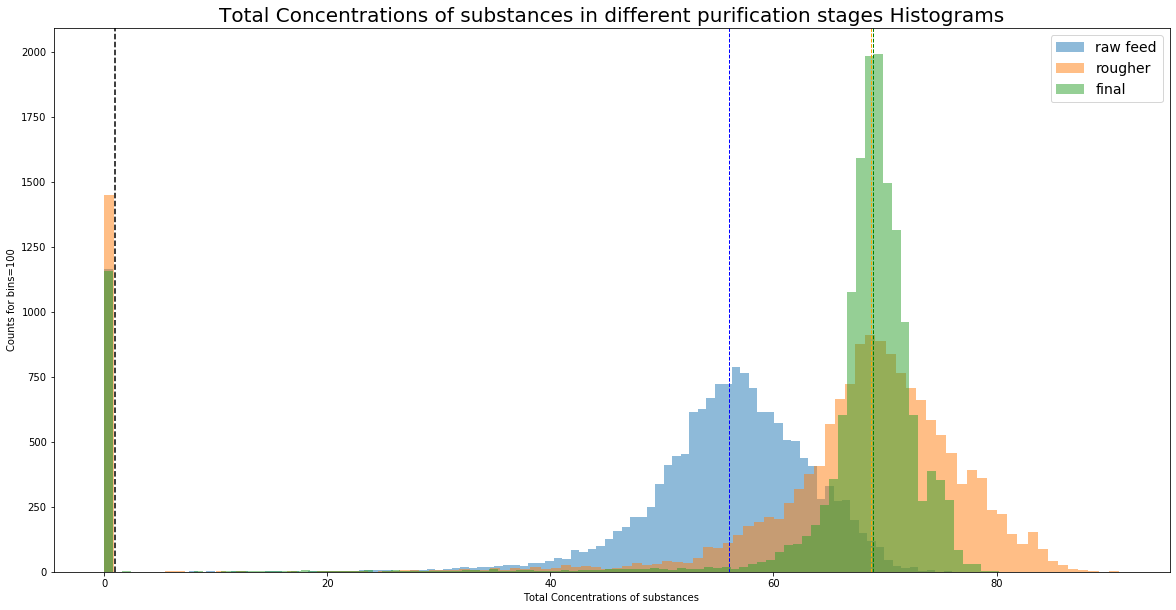

In [133]:
colors = ['b','orange','g']
plt.figure(figsize=(20,10))
plt.title('Total Concentrations of substances in different purification stages Histograms', fontsize=20)
total_conc = {}
total_conc['feed'] = 0
for subs in ['ag','pb','sol','au']:
    total_conc['feed'] += imputed.loc[:, 'rougher.input.feed_'+subs]
plt.hist(total_conc['feed'], \
         bins=100,alpha=0.5, label='raw feed')
plt.axvline(total_conc['feed'].median(), \
            color=colors[0], linestyle='dashed', linewidth=1)
j=1
for stage in ['rougher','final']:
    total_conc[stage] = 0
    for subs in ['ag','pb','sol','au']:
        total_conc[stage] += imputed.loc[:, stage+'.output.concentrate_'+subs]
    plt.hist(total_conc[stage], \
             bins=100,alpha=0.5, label=stage)
    plt.axvline(total_conc[stage].median(), \
                color=colors[j], linestyle='dashed', linewidth=1)
    j+=1
plt.axvline(1,color='k',linestyle='dashed')
plt.xlabel('Total Concentrations of substances')
plt.ylabel('Counts for bins=100')
plt.legend(loc='upper right', fontsize=14)

As noted in data preparation stage, it is better to remove all almost-zero concentrations if we are not expected to predict the whole test set as it is, since test set also contains feed concentrations=0 and those entries must be taken care of one way or another.
If the model should work for any incoming test set it is better to keep those anomalies because we don't know the margins of a new set.

In [134]:
imputed_data['test']['features'].loc[imputed_data['test']['features'][f]==0,:].shape

(369, 58)

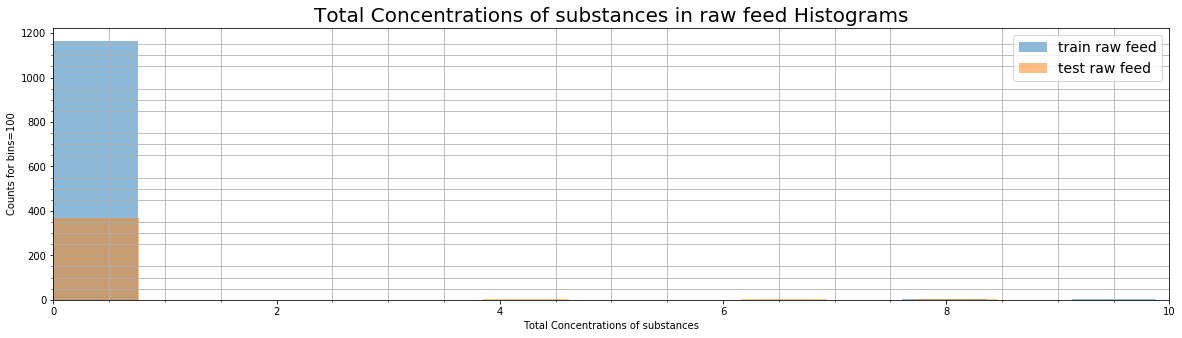

In [135]:
fig, ax = plt.subplots(figsize=(20,5))
#plt.figure(figsize=(20,10))
plt.title('Total Concentrations of substances in raw feed Histograms', fontsize=20)
total_conc_train = 0
total_conc_test = 0
for subs in ['ag','pb','sol','au']:
    total_conc_train += imputed_data['train']['features'].loc[:, 'rougher.input.feed_'+subs]
    total_conc_test += imputed_data['test']['features'].loc[:, 'rougher.input.feed_'+subs]
plt.hist(total_conc_train, bins=100,alpha=0.5, label='train raw feed')
plt.hist(total_conc_test, bins=100,alpha=0.5, label='test raw feed')
j=1
ax.minorticks_on()    
ax.grid(which='minor')
plt.xlim(0,10)
plt.xlabel('Total Concentrations of substances')
plt.ylabel('Counts for bins=100')
plt.legend(loc='upper right', fontsize=14)

There are anomalies both in raw feed and in later stages, this means we must handle train and test sets differently because test set is missing the data about rougher,final outputs. I chose to remove those entries from train set although it might be problematic in cases similar anomalies might show in test set due to a failure in early parameters.

In [136]:
#removing anomalies of raw feed from both samples and of rougher, final from train set
final_data = defaultdict(dict)
ind_0_feed_test = imputed_data['test']['features'][total_conc_test<1.5].index
ind_0_feed_train = imputed_data['train']['features'][total_conc_train<1.5].index
ind_0_final = imputed_data['train']['features'][(total_conc['rougher']<1.5) | (total_conc['final']<1.5)].index

final_data['test']['features'] = imputed_data['test']['features'].drop(ind_0_feed_test)
final_data['train']['features'] = imputed_data['train']['features'].drop(ind_0_feed_train.union(ind_0_final))
final_data['train']['targets'] = imputed_data['train']['targets'].drop(ind_0_feed_train.union(ind_0_final))

In [137]:
ind_0_feed_full = imputed[total_conc_train<1.5].index
ind_0_final_full = imputed[(total_conc['rougher']<1.5) | (total_conc['final']<1.5)].index

imputed = imputed.drop(ind_0_feed_full.union(ind_0_final_full))

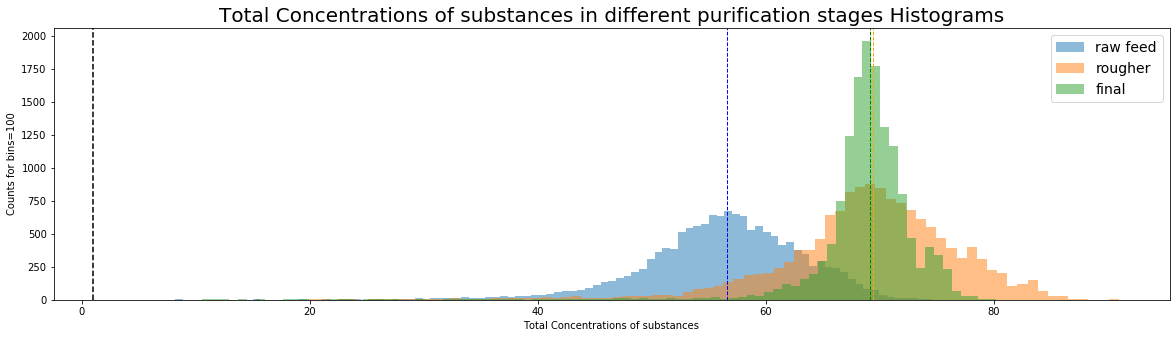

In [138]:
colors = ['b','orange','g']
plt.figure(figsize=(20,5))
plt.title('Total Concentrations of substances in different purification stages Histograms', fontsize=20)
total_conc_ = 0
for subs in ['ag','pb','sol','au']:
    total_conc_ += imputed.loc[:, 'rougher.input.feed_'+subs]
plt.hist(total_conc_, \
         bins=100,alpha=0.5, label='raw feed')
plt.axvline(total_conc_.median(), \
            color=colors[0], linestyle='dashed', linewidth=1)
j=1
for stage in ['rougher','final']:
    total_conc_ = 0
    for subs in ['ag','pb','sol','au']:
        total_conc_ += imputed.loc[:, stage+'.output.concentrate_'+subs]
    plt.hist(total_conc_, \
             bins=100,alpha=0.5, label=stage)
    plt.axvline(total_conc_.median(), \
                color=colors[j], linestyle='dashed', linewidth=1)
    j+=1
plt.axvline(1,color='k',linestyle='dashed')
plt.xlabel('Total Concentrations of substances')
plt.ylabel('Counts for bins=100')
plt.legend(loc='upper right', fontsize=14)

Anomalies removed.

In [139]:
#removing anomalies from both samples before imputation

data_prep['test']['features'] = data_prep['test']['features'].drop(ind_0_feed_test)
data_prep['train']['features'] = data_prep['train']['features'].drop(ind_0_feed_train.union(ind_0_final))
data_prep['train']['targets'] = data_prep['train']['targets'].drop(ind_0_feed_train.union(ind_0_final))

In [140]:
data_prep['train']['features'].shape

(14336, 90)

In [141]:
data_prep['train']['targets'].shape

(14336, 2)

In [142]:
final_data['train']['features'].shape

(14336, 58)

In [143]:
final_data['train']['targets'].shape

(14336, 2)

# Building model

## sMAPE

In [144]:
def smape(target, predicted):
    if isinstance(target,pd.Series):
        T = target.to_numpy()
    else:
        T = target
    if isinstance(predicted,pd.Series):
        P = predicted.to_numpy()
    else:
        P = predicted
    return 100/ \
            len(T) * \
            np.sum(2 * \
            np.abs(P - T) / \
            (np.abs(T) + np.abs(P) + np.finfo(float).eps))

In [145]:
def smape_final(rougher,final):
    return 0.25*rougher+0.75*final

## Training models

In [146]:
data['train']['date'].describe()

count                   16860
unique                  16860
top       2018-03-27 19:59:59
freq                        1
first     2016-01-15 00:00:00
last      2018-08-18 10:59:59
Name: date, dtype: object

In [147]:
data['test']['date'].describe()

count                    5856
unique                   5856
top       2017-10-01 00:59:59
freq                        1
first     2016-09-01 00:59:59
last      2017-12-31 23:59:59
Name: date, dtype: object

In [148]:
data['train'].reindex(data['train']['date']).index.intersection(data['test'].reindex(data['test']['date']).index)

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)

In [149]:
(data_prep['train']['features'].loc[:,['year','month','day']] \
 .eq(data_prep['test']['features'].loc[:,['year','month','day']])).sum()

year     2587
month       0
day         0
dtype: int64

In [150]:
data_prep['train']['features'].loc[:,['year','month']].drop_duplicates()

,year,month
0,2016,1
408,2016,2
1104,2016,3
1852,2016,4
2569,2016,5
3313,2016,6
4033,2016,7
4777,2016,8
5521,2017,1
6265,2017,2


In [151]:
data_prep['test']['features'].loc[:,['year','month']].drop_duplicates()

,year,month
0,2016,9
720,2016,10
1464,2016,11
2184,2016,12
2928,2017,9
3648,2017,10
4392,2017,11
5112,2017,12


In [152]:

data_prep['train']['features'].loc[:,['year','month']] \
    .groupby(data_prep['train']['features'].loc[:,['year','month']].columns.tolist(),as_index=False).size()

year  month
2016  1        358
      2        679
      3        635
      4        537
      5        670
      6        700
      7        601
      8        685
2017  1        575
      2        647
      3        639
      4        674
      5        516
      6        603
      7        693
      8        700
2018  1        374
      2        526
      3        649
      4        631
      5        647
      6        661
      7        569
      8        367
dtype: int64

In [153]:
recovery_100_ind = data_prep['train']['targets'].loc[(data_prep['train']['targets']==100).any(axis=1),:].index

In [154]:
#dropping entries with targets=100
data_prep['train']['features'] = data_prep['train']['features'].drop(recovery_100_ind)
data_prep['train']['targets'] = data_prep['train']['targets'].drop(recovery_100_ind)

The data is a time series and test set contains only measurments is months that proceed the months in train set in the same year. Therefore cross validation should be done in the same manner:

fold 1: train: 1,2 test: 3

fold 2: train: 1,2,3 test: 4,5

fold 3: train: 1,2,3,4 test: 5,6,7

fold 4: train: 1,2,3,4,5 test: 6,7,8

fold 5: train: 1,2,3,4,5,6 test: 7,8

In [189]:
def cross_validate(model, features, target,col_diff=None, score='smape', impute=True, \
                   scaler=None ,scale=False,scale_col=None):
    #save all scores in df
    scores = pd.DataFrame(index=range(0,5), columns=['smape'])
    #save sanity checks in df
    sanity_check = pd.DataFrame(index=range(0,5), columns=['constant median'])
    fold=0
    
    valid_months = [[3],[4,5],[5,6], [6,7,8],[7,8]]
    
    
    #iterate over splits
    for month in range(3,8):
        #copying sets to perform scales / imputation
        train_index = features.loc[features['month']<month,:].index
        #valid_index = features.loc[features['month']==month,:].index
        valid_index = features.loc[features['month'].isin(valid_months[fold]),:].index
        
        
        
        features_train_edit_full = features.loc[train_index,:].copy()
        features_train_edit = features_train_edit_full.drop(col_diff, axis=1)
        target_train_edit = target[train_index].copy()
        features_valid_edit = features.loc[valid_index,:].drop(col_diff, axis=1)
        target_valid_edit = target[valid_index].copy()
#        print(target_train_edit.mean(), target_valid_edit.mean())
        #impute data
        if impute:
            #features_train_edit, features_valid_edit = impute_data(features_train_edit,features_valid_edit)
            features_train_edit = features_train_edit.fillna(method='ffill')
            features_valid_edit = features_valid_edit.fillna(method='ffill')
            na_ind_train = features_train_edit.loc[features_train_edit.isna().any(axis=1),:].index
            na_ind_valid = features_valid_edit.loc[features_valid_edit.isna().any(axis=1),:].index
            #print(features_train_edit.isna().sum(),len(na_ind_train),features_valid_edit.isna().sum(), len(na_ind_valid))
            target_train_edit = target_train_edit.drop(na_ind_train)
            target_valid_edit = target_valid_edit.drop(na_ind_valid)
            features_train_edit = features_train_edit.dropna()
            features_valid_edit = features_valid_edit.dropna()
            if target.name == 'rougher.output.recovery':
                #full_features = impute_data(features_train_edit_full)[0]
                features_train_edit_full = features_train_edit_full.fillna(method='ffill')
                na_ind_train_full = features_train_edit_full.loc[features_train_edit_full.isna().any(axis=1),:].index
                target_train_edit = target_train_edit.drop(na_ind_train_full)
                features_train_edit_full = features_train_edit_full.dropna()
                #recalculating rougher.output
                recovery_re_calculated =  \
                    recovery_calc(
                    features_train_edit_full[c], \
                    features_train_edit_full[f], \
                    features_train_edit_full[t])
                #dropping out of range
                recovery_re_calculated = recovery_re_calculated. \
                    drop(recovery_re_calculated[recovery_re_calculated>100].index \
                         .union(recovery_re_calculated[recovery_re_calculated<0].index))
                #filling missing rougher output recovery
                target_train_edit = target_train_edit.fillna(recovery_re_calculated)
                #removing remaining nulls
                na_ind_ = target_train_edit[target_train_edit.isna()].index
                features_train_edit = features_train_edit.drop(na_ind_)
                target_train_edit = target_train_edit.dropna()
                #removing nulls from valid
                na_ind_valid = target_valid_edit[target_valid_edit.isna()].index
                features_valid_edit = features_valid_edit.drop(na_ind_valid)
                target_valid_edit = target_valid_edit.dropna()                
            
        #scale data
        if scale and scaler is not None and scale_col is not None:
            scaler.fit(features_train_edit[scale_col])
            features_train_edit.loc[:,scale_col] = scaler.transform(features_train_edit[scale_col])
            features_valid_edit.loc[:,scale_col] = scaler.transform(features_valid_edit[scale_col])
        #train model
        model.fit(features_train_edit,target_train_edit)
        #evaluate predictions
        predicted_valid = model.predict(features_valid_edit)
        #perform sanity check
        #sMAPE score for a constant model with all medians
        sanity_check.loc[fold,'constant median'] =  \
            smape(target_valid_edit,(pd.Series(target_train_edit.median(),target_valid_edit.index)))
        #sMAPE score for predicted
        scores.loc[fold,'smape'] = smape(target_valid_edit, predicted_valid)
        fold+=1
    return scores, sanity_check
    

### Training model to predict final.output.recovery

#### Decision Tree

In [289]:
#cross validating decision trees in different depth
scores_dict = {} 
sanity_check_dict = {}
for depth in range(2,10):
    model = DecisionTreeRegressor(criterion='mse', max_depth=depth)
    scores_dict[depth], sanity_check_dict[depth] = \
        cross_validate(model, \
                    data_prep['train']['features'], data_prep['train']['targets']['final.output.recovery'], col_diff)
    

In [290]:
#printing sMAPE scores and sanity check for each depth
for key in scores_dict.keys():
    print('depth: ', key,'\n','mean sMAPE: ',scores_dict[key].mean(),'\n', \
          pd.concat([scores_dict[key],sanity_check_dict[key]], axis=1))

depth:  2 
 mean sMAPE:  smape    10.144732
dtype: float64 
      smape constant median
0  9.83762         10.2077
1  11.8381         11.3151
2  11.3108         12.4196
3  9.21774         10.6817
4  8.51933         10.1063
depth:  3 
 mean sMAPE:  smape    10.408163
dtype: float64 
      smape constant median
0  10.5233         10.2077
1  12.3065         11.3151
2  11.2386         12.4196
3  9.03094         10.6817
4  8.94143         10.1063
depth:  4 
 mean sMAPE:  smape    11.652568
dtype: float64 
      smape constant median
0  12.4736         10.2077
1   15.526         11.3151
2  11.2332         12.4196
3  9.67225         10.6817
4  9.35775         10.1063
depth:  5 
 mean sMAPE:  smape    11.938689
dtype: float64 
      smape constant median
0  13.1022         10.2077
1  16.0933         11.3151
2  11.4485         12.4196
3  9.74269         10.6817
4  9.30667         10.1063
depth:  6 
 mean sMAPE:  smape    12.488226
dtype: float64 
      smape constant median
0  13.2538         1

As depth getting larger than 3 there's more overfitting and high sMAPE errors.

#### Random Forest

In [291]:
#cross validating random forest models in different number of estimators without max depth
scores_dict_RF_nomax = {} 
sanity_check_dict_RF_nomax = {}
for n in range(3,20):
    model = RandomForestRegressor(n_estimators=n, criterion='mse')
    scores_dict_RF_nomax[n], sanity_check_dict_RF_nomax[n] = \
        cross_validate(model, \
                    data_prep['train']['features'], data_prep['train']['targets']['final.output.recovery'], col_diff)

In [292]:
#printing sMAPE scores and sanity check for each number of estimators
for N in scores_dict_RF_nomax.keys():
    print('N: ' , N,'\n','mean sMAPE: ',scores_dict_RF_nomax[N].mean(),'\n', \
          pd.concat([scores_dict_RF_nomax[N],sanity_check_dict_RF_nomax[N]], axis=1))

N:  3 
 mean sMAPE:  smape    12.181386
dtype: float64 
      smape constant median
0  11.7336         10.2077
1  12.2898         11.3151
2  12.9535         12.4196
3  12.2103         10.6817
4  11.7197         10.1063
N:  4 
 mean sMAPE:  smape    11.71426
dtype: float64 
      smape constant median
0  11.6374         10.2077
1  13.1186         11.3151
2  11.9526         12.4196
3  11.3812         10.6817
4  10.4816         10.1063
N:  5 
 mean sMAPE:  smape    12.168744
dtype: float64 
      smape constant median
0  15.2657         10.2077
1  12.0334         11.3151
2  12.1073         12.4196
3  11.2676         10.6817
4  10.1697         10.1063
N:  6 
 mean sMAPE:  smape    11.177129
dtype: float64 
      smape constant median
0  11.3431         10.2077
1  12.1052         11.3151
2   12.316         12.4196
3  10.7485         10.6817
4  9.37296         10.1063
N:  7 
 mean sMAPE:  smape    11.139021
dtype: float64 
      smape constant median
0  11.5832         10.2077
1  11.8446    

In [213]:
#printing sMAPE scores and sanity check for each number of estimators
for N in scores_dict_RF_nomax.keys():
    print('N: ' , N,'\n','mean sMAPE: ',scores_dict_RF_nomax[N].mean(),'\n', \
          pd.concat([scores_dict_RF_nomax[N],sanity_check_dict_RF_nomax[N]], axis=1))

N:  3 
 mean sMAPE:  smape    13.751387
dtype: float64 
      smape constant median
0  13.2808         10.5571
1  14.5407         11.4446
2  13.9883         12.5754
3  13.6043         10.9175
4  13.3427         10.3653
N:  4 
 mean sMAPE:  smape    13.674581
dtype: float64 
      smape constant median
0   14.585         10.5571
1   14.817         11.4446
2  13.3406         12.5754
3  12.6864         10.9175
4   12.944         10.3653
N:  5 
 mean sMAPE:  smape    12.667056
dtype: float64 
      smape constant median
0  14.7189         10.5571
1  12.5227         11.4446
2  12.1041         12.5754
3  12.9086         10.9175
4   11.081         10.3653
N:  6 
 mean sMAPE:  smape    11.879044
dtype: float64 
      smape constant median
0  13.2014         10.5571
1  12.0992         11.4446
2  11.9031         12.5754
3  11.2244         10.9175
4  10.9672         10.3653
N:  7 
 mean sMAPE:  smape    12.415319
dtype: float64 
      smape constant median
0  14.3616         10.5571
1  13.3211   

Large sMAPE errors for random forest, too much overfitting

Training random forest with max depth = 3:

In [192]:
#cross validating random forest models in different number of estimators with max depth=3
scores_dict_RF = {} 
sanity_check_dict_RF = {}
for n in range(4,20):
    model = RandomForestRegressor(n_estimators=n, criterion='mse',max_depth=2)
    scores_dict_RF[n], sanity_check_dict_RF[n] = \
        cross_validate(model, \
                    data_prep['train']['features'], data_prep['train']['targets']['final.output.recovery'], col_diff)

In [193]:
#printing sMAPE scores and sanity check for each number of estimators
for N in scores_dict_RF.keys():
    print('N: ' , N, '\n','mean sMAPE: ',scores_dict_RF[N].mean(),'\n', \
          pd.concat([scores_dict_RF[N], sanity_check_dict_RF[N]], axis=1))

N:  4 
 mean sMAPE:  smape    9.940219
dtype: float64 
      smape constant median
0   9.6522         10.2077
1  11.2561         11.3151
2  11.5419         12.4196
3  8.98331         10.6817
4  8.26755         10.1063
N:  5 
 mean sMAPE:  smape    9.984165
dtype: float64 
      smape constant median
0  10.2443         10.2077
1  11.1651         11.3151
2  11.0194         12.4196
3  9.00246         10.6817
4  8.48953         10.1063
N:  6 
 mean sMAPE:  smape    9.820768
dtype: float64 
      smape constant median
0  9.68123         10.2077
1  10.8134         11.3151
2  11.1302         12.4196
3  9.05103         10.6817
4  8.42793         10.1063
N:  7 
 mean sMAPE:  smape    9.793218
dtype: float64 
      smape constant median
0  9.26095         10.2077
1  11.2578         11.3151
2  11.2021         12.4196
3  8.92462         10.6817
4  8.32058         10.1063
N:  8 
 mean sMAPE:  smape    9.821202
dtype: float64 
      smape constant median
0  9.25022         10.2077
1  11.2217        

In [215]:
sanity_check_dict_RF[19].mean()

constant median    10.946099
dtype: float64

The best model so far is random forest with max depth=2 and N=19, achieving better results than constant median and an avarage error of 9.73 in cross validation (compared with 10.94 average error of median)

#### Linear Regression

In [175]:

scaler = StandardScaler()
scale_col = data_prep['test']['features'].columns
model = LinearRegression()
scores_dict_lin, sanity_check_dict_lin = \
        cross_validate(model, \
                    data_prep['train']['features'], data_prep['train']['targets']['final.output.recovery'], col_diff, \
                       score='smape', impute=True, \
                   scaler=scaler ,scale=True,scale_col=scale_col)

In [176]:
print('mean sMAPE: ',scores_dict_lin.mean(),'\n', \
      pd.concat([scores_dict_lin, sanity_check_dict_lin], axis=1))

mean sMAPE:  smape    10.873971
dtype: float64 
      smape constant median
0  10.0365         9.35505
1  11.4647         12.9282
2  14.2274          11.815
3  10.3547         10.8506
4  8.28652         9.83381


sMAPE errors are larger than RF with max depth=3.

### Training model to predict rougher.output.recovery

#### Decision Tree

In [264]:
#cross validating decision trees in different depth
scores_dict_rougher_DT = {} 
sanity_check_dict_rougher_DT = {}
for depth in range(2,8):
    model = DecisionTreeRegressor(criterion='mae', max_depth=depth, random_state=12)
    scores_dict_rougher_DT[depth], sanity_check_dict_rougher_DT[depth] = \
        cross_validate(model, \
                    data_prep['train']['features'], data_prep['train']['targets']['rougher.output.recovery'], col_diff)
    

In [265]:
#printing sMAPE scores and sanity check for each depth
for key in scores_dict_rougher_DT.keys():
    print('depth: ', key,'\n','mean sMAPE: ',scores_dict_rougher_DT[key].mean(),'\n', \
          pd.concat([scores_dict_rougher_DT[key],sanity_check_dict_rougher_DT[key]], axis=1))

depth:  2 
 mean sMAPE:  smape    7.741846
dtype: float64 
      smape constant median
0  8.25243         6.82437
1  7.02272         9.56965
2  9.54226          10.422
3  6.24871         7.70756
4  7.64311         6.96874
depth:  3 
 mean sMAPE:  smape    7.175626
dtype: float64 
      smape constant median
0  7.60968         6.82437
1  6.87123         9.56965
2  9.07315          10.422
3  6.08584         7.70756
4  6.23823         6.96874
depth:  4 
 mean sMAPE:  smape    7.053401
dtype: float64 
      smape constant median
0  7.57364         6.82437
1  6.66669         9.56965
2  8.77186          10.422
3   6.2452         7.70756
4  6.00962         6.96874
depth:  5 
 mean sMAPE:  smape    8.806714
dtype: float64 
      smape constant median
0  7.74062         6.82437
1  7.47589         9.56965
2  8.43068          10.422
3  6.66898         7.70756
4  13.7174         6.96874
depth:  6 
 mean sMAPE:  smape    8.505123
dtype: float64 
      smape constant median
0  7.53112         6.8243

As depth getting larger than 4 there's more overfitting and high sMAPE errors.

#### Random Forest

In [275]:
#cross validating random forest models in different number of estimators with max depth=3
scores_dict_rougher_RF = {} 
sanity_check_dict_rougher_RF = {}
for n in range(5,10):
    model = RandomForestRegressor(n_estimators=n, criterion='mae',max_depth=4, random_state=12345)
    scores_dict_rougher_RF[n], sanity_check_dict_rougher_RF[n] = \
        cross_validate(model, \
                    data_prep['train']['features'], data_prep['train']['targets']['rougher.output.recovery'], col_diff)

In [276]:
#printing sMAPE scores and sanity check for each number of estimators
for N in scores_dict_rougher_RF.keys():
    print('N: ' , N, '\n','mean sMAPE: ',scores_dict_rougher_RF[N].mean(),'\n', \
          pd.concat([scores_dict_rougher_RF[N], sanity_check_dict_rougher_RF[N]], axis=1))

N:  5 
 mean sMAPE:  smape    7.084291
dtype: float64 
      smape constant median
0  7.28789         6.82437
1  7.29501         9.56965
2  8.54586          10.422
3  5.96776         7.70756
4  6.32494         6.96874
N:  6 
 mean sMAPE:  smape    7.051863
dtype: float64 
      smape constant median
0  7.25518         6.82437
1  7.45173         9.56965
2  8.46689          10.422
3  5.83029         7.70756
4  6.25522         6.96874
N:  7 
 mean sMAPE:  smape    6.973042
dtype: float64 
      smape constant median
0  6.96915         6.82437
1  7.30402         9.56965
2  8.46495          10.422
3  5.78702         7.70756
4  6.34007         6.96874
N:  8 
 mean sMAPE:  smape    6.964192
dtype: float64 
      smape constant median
0  6.93643         6.82437
1  7.40283         9.56965
2  8.48998          10.422
3  5.75572         7.70756
4    6.236         6.96874
N:  9 
 mean sMAPE:  smape    6.98411
dtype: float64 
      smape constant median
0    6.919         6.82437
1  7.50849         

In [203]:
sanity_check_dict_rougher_RF[6].mean()

constant median    8.23719
dtype: float64

The best model for rougher recovery is random forest with N=8 and max depth=4, with an average error of 6.96 compared with 8.23 of median.

## Final evaluation

In [160]:
#getting test target true values from source file
test_target =  \
    data['source'].loc[data['source']['date'].dt.month > 8,['date','rougher.output.recovery','final.output.recovery']]

In [161]:
test_target.shape

(5856, 3)

In [162]:
final_data['test']['features'].shape[0]

5486

In [163]:
for attr in ['year', 'month', 'day', 'hour', 'minute']:
    test_target.loc[:,attr] = getattr(test_target.loc[:,'date'].dt, attr)
test_target.head()

,date,rougher.output.recovery,final.output.recovery,year,month,day,hour,minute
0,2016-09-01 00:59:59,87.107763,70.541216,2016,9,1,0,59
1,2016-09-01 01:59:59,86.843261,69.266198,2016,9,1,1,59
2,2016-09-01 02:59:59,86.842308,68.116445,2016,9,1,2,59
3,2016-09-01 03:59:59,87.226430,68.347543,2016,9,1,3,59
4,2016-09-01 04:59:59,86.688794,66.927016,2016,9,1,4,59


In [164]:
#getting the joint entries of test target and test features according to dates 
mask=final_data['test']['features'].loc[:,['year', 'month', 'day', 'hour', 'minute']] \
    .eq(test_target.loc[:,['year', 'month', 'day', 'hour', 'minute']]).all(axis=1)

In [165]:
test_target = test_target.loc[mask,['rougher.output.recovery','final.output.recovery']]
test_target = test_target.reindex(final_data['test']['features'].index)
test_target.shape

(5486, 2)

In [166]:
test_target.loc[test_target.isna().any(axis=1),:].index

Int64Index([  49,   53,   99,  100,  101,  102,  103,  104,  105,  106,
            ...
            5840, 5841, 5842, 5843, 5844, 5845, 5846, 5847, 5848, 5849],
           dtype='int64', length=837)

Test targets contain nulls so it's only possible to evaluate sMAPE for existing entries.

In [167]:
final_na_index = test_target.loc[test_target['final.output.recovery'].isna(),'final.output.recovery'].index

In [168]:
rougher_na_index = test_target.loc[test_target['rougher.output.recovery'].isna(),'rougher.output.recovery'].index

### Final evaluation of final.output.recovery

In [231]:
final_model = RandomForestRegressor(n_estimators=19, criterion='mse', max_depth=2, random_state=12345)
final_model.fit(final_data['train']['features'].drop(recovery_100_ind),final_data['train']['targets']['final.output.recovery'].drop(recovery_100_ind))
final_recovery = final_model.predict(final_data['test']['features'])

In [232]:
final_recovery = pd.Series(final_recovery, index=final_data['test']['features'].index)

In [233]:
final_final_smape = \
    smape(test_target['final.output.recovery'].drop(final_na_index),final_recovery.drop(final_na_index))
final_final_smape

12.031267366541565

In [245]:
#sanity check
final_sanity_check = smape(test_target['final.output.recovery'].drop(final_na_index), \
      pd.Series(final_data['train']['targets']['final.output.recovery'].median(), \
                test_target['final.output.recovery'].drop(final_na_index).index))
final_sanity_check

11.834286055308107

After lots of trainings and fine tuning I managed to reach only 12.03% error which is higher than median evaluation.

### Final evaluation of rougher.output.recovery

In [286]:
final_model = RandomForestRegressor(n_estimators=8, criterion='mae',max_depth=4, random_state=12)
final_model.fit(final_data['train']['features'],final_data['train']['targets']['rougher.output.recovery'])
rougher_recovery = final_model.predict(final_data['test']['features'])

In [287]:
rougher_recovery = pd.Series(rougher_recovery, index=final_data['test']['features'].index)

In [288]:
final_rougher_smape = \
smape(test_target['rougher.output.recovery'].drop(rougher_na_index),rougher_recovery.drop(rougher_na_index))
final_rougher_smape

14.306973161264917

In [244]:
#sanity check
rougher_sanity_check = smape(test_target['rougher.output.recovery'].drop(rougher_na_index), \
      pd.Series(final_data['train']['targets']['rougher.output.recovery'].median(), \
                test_target['rougher.output.recovery'].drop(rougher_na_index).index))
rougher_sanity_check

14.69998046933919

The chosen model performs only 2.67% better than median evaluation.

### Final sMAPE error

In [289]:
smape_final(final_rougher_smape,final_final_smape)

12.600193815222404

In [246]:
#sanity check
smape_final(final_sanity_check,rougher_sanity_check)

13.983556865831419

Final sMAPE error for evaluation of both final and rougher recovery is 12.6%, only 9.9% better than medians error.